In [2]:
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from disambiguation_helper import load_fits_data, compute_B_perp, weak_field_mask, strong_field_mask
from disambiguation_helper import conversion_to_heliographic, compute_Bx_By
from acute_angle_method import AAM_azimuth
from non_potential_field_calculation import NPFC_fields, NPFC_azimuth
from minimum_energy_method import MEM

#### We import data and proceed with definition of weak-mask and strong mask
#### in order to apply acute-angle-method and minimum-energy method.

In [3]:
atmos = fits.open('pole_atm_original.fits')[0].data[:,:,256:512,256:512]
B_orig, inc_orig, az_orig = atmos[4,30], np.radians(atmos[6,30]), np.radians(atmos[7,30])

ptpc = fits.open('deprojected_ptp_convolved.fits')[0].data[256:512,256:512,:]
B_ptpc, inc_ptpc, az_ptpc = ptpc[:,:,0], ptpc[:,:,1], ptpc[:,:,2]

spc = fits.open('deprojected_spatially_coupled.fits')[0].data[256:512,256:512]
B_spc, inc_spc, az_spc = spc[:,:,0], spc[:,:,1], spc[:,:,2]

Btr_orig = compute_B_perp(B_orig, inc_orig)
Btr_ptpc = compute_B_perp(B_ptpc, inc_ptpc)
Btr_spc = compute_B_perp(B_spc, inc_spc)

wr_orig, _ = weak_field_mask(Btr_orig, "orig")
wr_ptpc, _ = weak_field_mask(Btr_ptpc, "ptpc")
wr_spc, _ = weak_field_mask(Btr_spc, "spc")

strong_mask_orig = strong_field_mask(B_orig, "orig")
strong_mask_ptpc = strong_field_mask(B_ptpc, "ptpc")
strong_mask_spc = strong_field_mask(B_spc, "spc")

B_r_orig, B_theta_orig, B_phi_orig = conversion_to_heliographic(B_orig, inc_orig, az_orig)
B_r_ptpc, B_theta_ptpc, B_phi_ptpc = conversion_to_heliographic(B_ptpc, inc_ptpc, az_ptpc)
B_r_spc, B_theta_spc, B_phi_spc = conversion_to_heliographic(B_spc, inc_spc, az_spc)

Bx_orig, By_orig = compute_Bx_By(Btr_orig, az_orig)
Bx_ptpc, By_ptpc = compute_Bx_By(Btr_ptpc, az_ptpc)
Bx_spc, By_spc = compute_Bx_By(Btr_spc, az_spc)

#### $\color{magenta}{\text{ ACUTE-ANGLE METHOD:}} $

In [4]:
az_aam_orig = np.radians(AAM_azimuth(np.degrees(az_orig))) # AAM returns azimuth in deg
az_aam_ptpc = np.radians(AAM_azimuth(np.degrees(az_ptpc)))
az_aam_spc = np.radians(AAM_azimuth(np.degrees(az_spc)))

Bx_aam_orig = B_orig * np.cos(inc_orig) * np.sin(az_aam_orig)
By_aam_orig = B_orig * np.sin(inc_orig) * np.sin(az_aam_orig)

Bx_aam_ptpc = B_ptpc * np.cos(inc_ptpc) * np.sin(az_aam_ptpc)
By_aam_ptpc = B_ptpc * np.sin(inc_ptpc) * np.sin(az_aam_ptpc)

Bx_aam_spc = B_spc * np.cos(inc_spc) * np.sin(az_aam_spc)
By_aam_spc = B_spc * np.sin(inc_spc) * np.sin(az_aam_spc)

AAM converged after 9 iterations


#### $\color{magenta}{\text{ MINIMUM ENERGY METHOD:}} $

In [5]:
strong_mask_orig = strong_field_mask(B_r_orig, "orig")
strong_mask_ptpc = strong_field_mask(B_r_ptpc, "ptpc")
strong_mask_spc = strong_field_mask(B_r_spc, "spc")

Bx_mem_orig, By_mem_orig, Bz_mem_orig, az_mem_orig = MEM(Bx_aam_orig, By_aam_orig, B_r_orig, strong_mask_orig, 'orig')
Bx_mem_ptpc, By_mem_ptpc, Bz_mem_ptpc, az_mem_ptpc = MEM(Bx_ptpc, By_ptpc, B_r_ptpc, strong_mask_ptpc, "ptpc")
Bx_mem_spc, By_mem_spc, Bz_mem_spc, az_mem_spc = MEM(Bx_spc, By_spc, B_r_spc, strong_mask_spc, "spc")

MEM completed!
MEM completed!
MEM completed!


#### $\color{magenta}{\text{NON-POTENTIAL FIELD CALCULATION:}} $

In [6]:
lambda_param = 1e5 # cm

Bx_npfc_orig, By_npfc_orig, Bz_npfc_orig = NPFC_fields(B_orig, inc_orig, az_orig, lambda_param)
Bx_npfc_ptpc, By_npfc_ptpc, Bz_npfc_ptpc = NPFC_fields(B_ptpc, inc_ptpc, az_ptpc, lambda_param)
Bx_npfc_spc, By_npfc_spc, Bz_npfc_spc = NPFC_fields(B_spc, inc_spc, az_spc, lambda_param)

az_npfc_orig = NPFC_azimuth(np.array(az_orig, dtype=np.float64))  
az_npfc_ptpc = NPFC_azimuth(np.array(az_ptpc, dtype=np.float64))
az_npfc_spc = NPFC_azimuth(np.array(az_spc, dtype=np.float64))

NPFC converged after 100 iterations with 4073 pixel flips.
NPFC converged after 1 iterations with 0 pixel flips.
NPFC converged after 100 iterations with 1066 pixel flips.
NPFC azimuth converged after 1 iterations.
NPFC azimuth converged after 1 iterations.
NPFC azimuth converged after 1 iterations.


#### $\color{red}{\text{We compare the results below. Before that, we make some necessary adjustments.}} $

In [32]:
Bz_aam_orig = B_orig * np.cos(inc_orig)
Bz_aam_ptpc = B_ptpc * np.cos(inc_ptpc)
Bz_aam_spc = B_spc * np.cos(inc_spc)

Btr_aam_orig = np.sqrt(Bx_aam_orig**2 + By_aam_orig**2)
Btr_mem_orig = np.sqrt(Bx_mem_orig**2 + By_mem_orig**2)
Btr_npfc_orig = np.sqrt(Bx_npfc_orig**2 + By_npfc_orig**2)

Btr_aam_ptpc = np.sqrt(Bx_aam_ptpc**2 + By_aam_ptpc**2)
Btr_mem_ptpc = np.sqrt(Bx_mem_ptpc**2 + By_mem_ptpc**2)
Btr_npfc_ptpc = np.sqrt(Bx_npfc_ptpc**2 + By_npfc_ptpc**2)

Btr_aam_spc = np.sqrt(Bx_aam_spc**2 + By_aam_spc**2)
Btr_mem_spc = np.sqrt(Bx_mem_spc**2 + By_mem_spc**2)
Btr_npfc_spc = np.sqrt(Bx_npfc_spc**2 + By_npfc_spc**2)

Bx_orig, By_orig = B_orig * np.cos(inc_orig) * np.sin(az_orig), B_orig * np.sin(inc_orig) * np.sin(az_orig) 
Bz_orig = B_orig * np.cos(inc_orig)

skip = 8
x, y = np.arange(0, B_orig.shape[1], skip), np.arange(0, B_orig.shape[0], skip)
X, Y = np.meshgrid(x, y)

Bx, By = Bx_orig[::skip, ::skip], By_orig[::skip, ::skip]
Bx_aam, By_aam = Bx_aam_orig[::skip, ::skip], By_aam_orig[::skip, ::skip]
Bx_mem, By_mem = Bx_mem_orig[::skip, ::skip], By_mem_orig[::skip, ::skip]
Bx_npfc, By_npfc = Bx_npfc_orig[::skip, ::skip], By_npfc_orig[::skip, ::skip]

#### $\color{red}{\text{We use 'quiver' in combination with contour plot.}} $
#### $\color{red}{\text{And, to get a different insight, we use 'streamplot'.}} $

#### Original atmosphere.

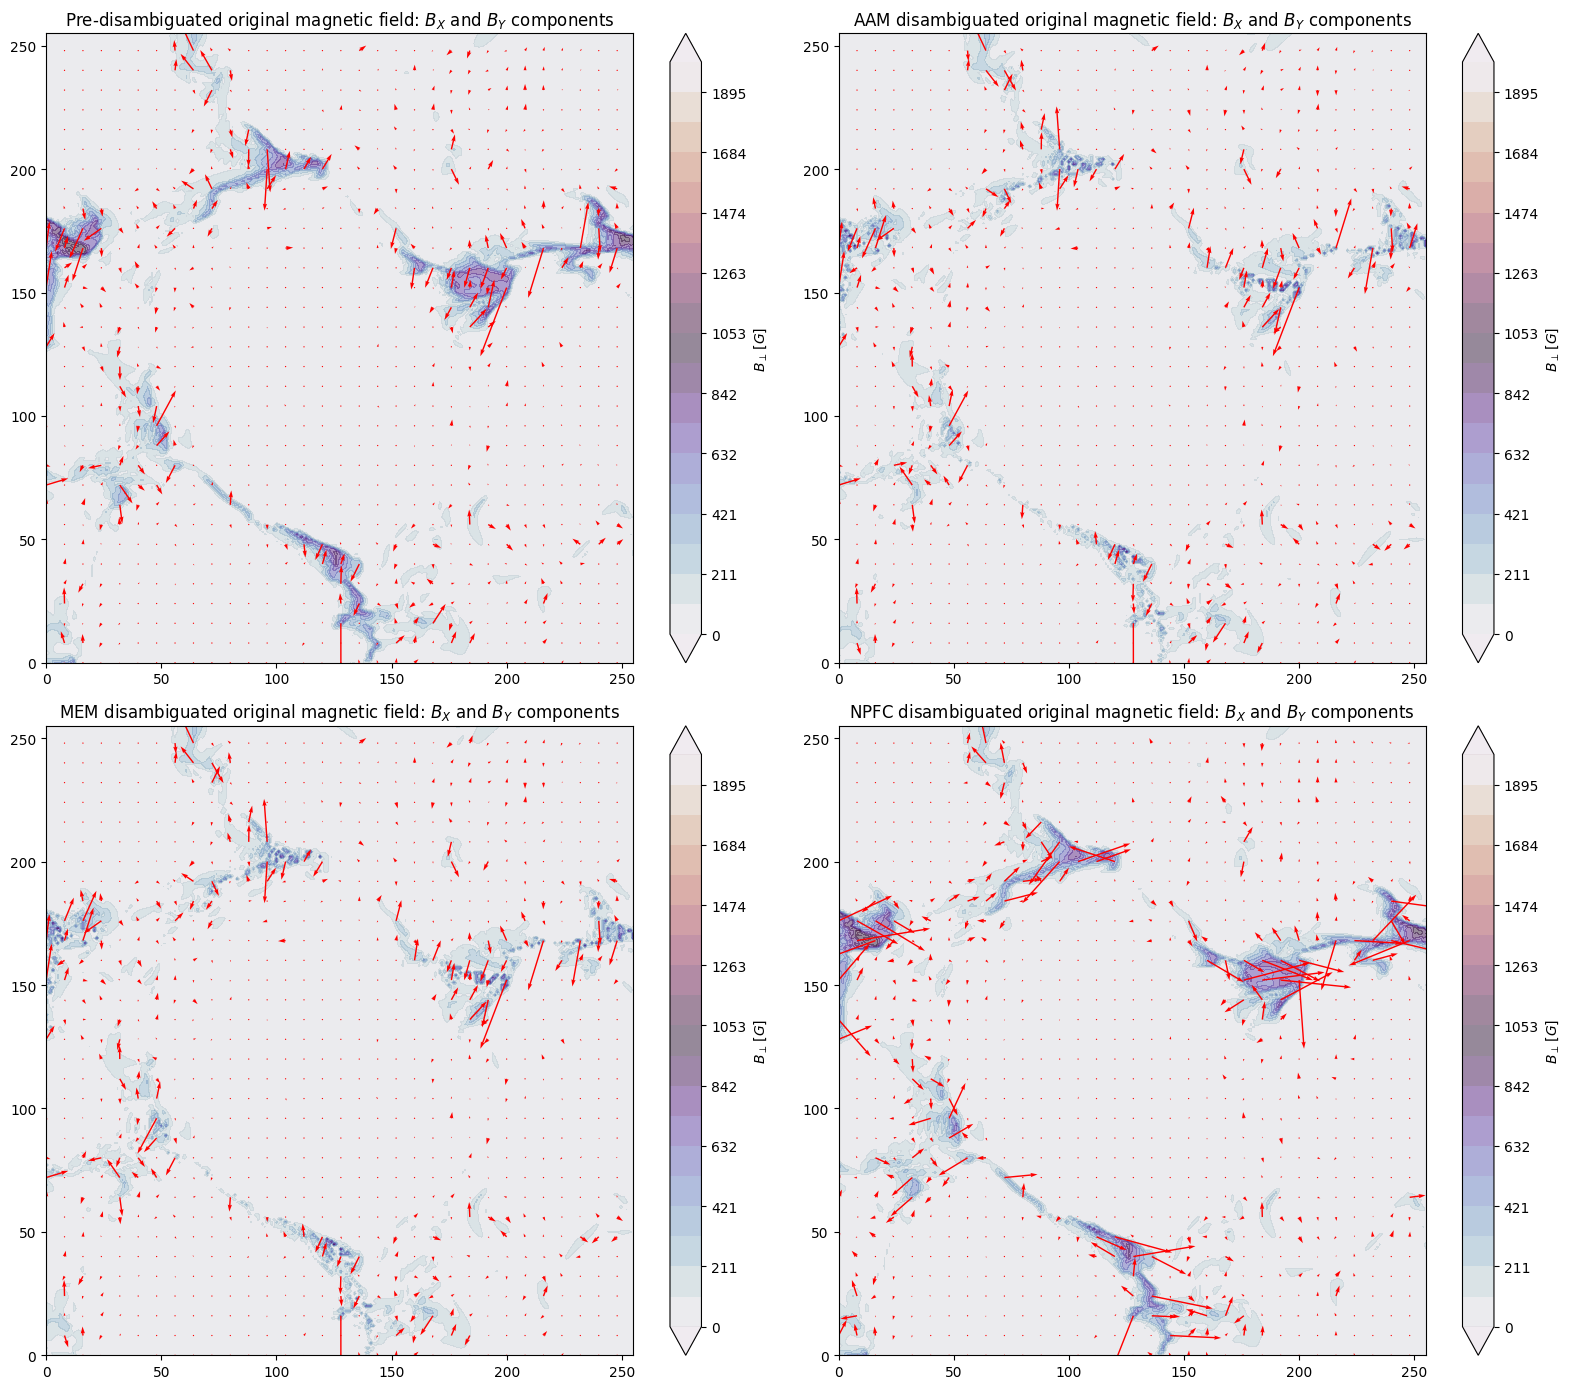

In [33]:
plt.figure(figsize=(16, 14))

levels = np.linspace(0, 2000, 20)  
plt.subplot(221)
contour = plt.contourf(Btr_orig, levels=levels, cmap='twilight', alpha=0.5, extend='both')
plt.colorbar(contour, label=r'$B_{\perp}\,[G]$')
plt.quiver(X, Y, Bx, By, color='red', angles='xy', scale_units='xy', lw=2, scale=25)
plt.title('Pre-disambiguated original magnetic field: $B_X$ and $B_Y$ components')

plt.subplot(222)
contour = plt.contourf(Btr_aam_orig, levels=levels, cmap='twilight', alpha=0.5, extend='both')
plt.colorbar(contour, label=r'$B_{\perp}\,[G]$')
plt.quiver(X, Y, Bx_aam, By_aam, color='red', angles='xy', scale_units='xy', lw=2, scale=25)
plt.title('AAM disambiguated original magnetic field: $B_X$ and $B_Y$ components')

plt.subplot(223)
contour = plt.contourf(Btr_mem_orig, levels=levels, cmap='twilight', alpha=0.5, extend='both')
plt.colorbar(contour, label=r'$B_{\perp}\,[G]$')
plt.quiver(X, Y, Bx_mem, By_mem, color='red', angles='xy', scale_units='xy', lw=2, scale=25)
plt.title('MEM disambiguated original magnetic field: $B_X$ and $B_Y$ components')

plt.subplot(224)
contour = plt.contourf(Btr_npfc_orig, levels=levels, cmap='twilight', alpha=0.5, extend='both')
plt.colorbar(contour, label=r'$B_{\perp}\,[G]$')
plt.quiver(X, Y, Bx_npfc, By_npfc, color='red', angles='xy', scale_units='xy', lw=2, scale=25)
plt.title('NPFC disambiguated original magnetic field: $B_X$ and $B_Y$ components')

plt.tight_layout()
plt.show()

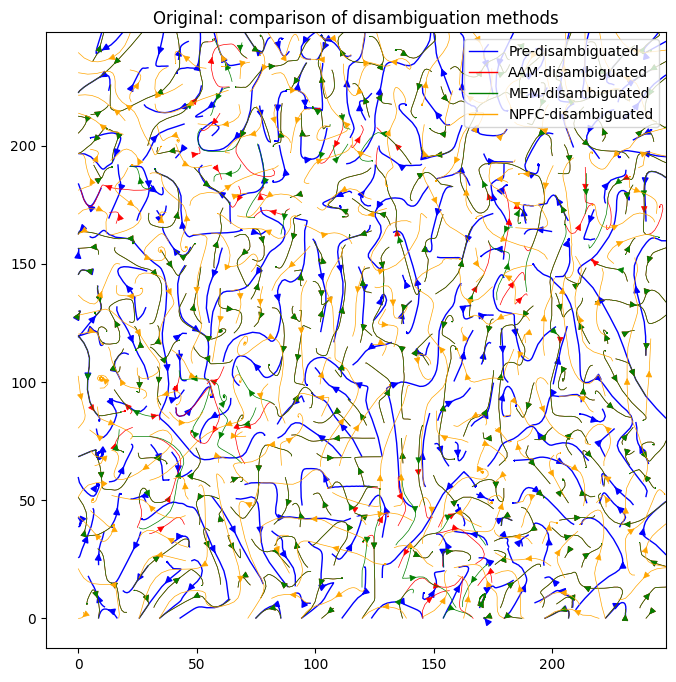

In [34]:
plt.figure(figsize=(8, 8))

sp1, sp2 = np.sqrt(Bx**2 + By**2), np.sqrt(Bx_aam**2 + By_aam**2)
sp3, sp4 = np.sqrt(Bx_mem**2 + By_mem**2), np.sqrt(Bx_npfc**2 + By_npfc**2)
#lw1, lw2, lw3, lw4 = 10*sp1/sp1.max(), 10*sp2/sp2.max(), 10*sp3/sp3.max(), 10*sp4/sp4.max()

plt.streamplot(X, Y, Bx/sp1.max(), By/sp1.max(), color='blue', linewidth=1)
plt.streamplot(X, Y, Bx_aam/sp2.max(), By_aam/sp2.max(), color='red', linewidth=0.5)
plt.streamplot(X, Y, Bx_mem/sp3.max(), By_mem/sp3.max(), color='green', linewidth=0.5)
plt.streamplot(X, Y, Bx_npfc/sp4.max(), By_npfc/sp4.max(), color='orange', linewidth=0.5)

legend_labels = ['Pre-disambiguated', 'AAM-disambiguated', 'MEM-disambiguated', 'NPFC-disambiguated']
legend_colors = ['blue', 'red', 'green', 'orange']
handles = [plt.Line2D([0], [0], color=color, lw=1) for color in legend_colors]
plt.title('Original: comparison of disambiguation methods')
plt.legend(handles, legend_labels, loc="upper right")
plt.show()

#### P-t-P-C inferred data.

In [35]:
skip = 8
x, y = np.arange(0, B_orig.shape[1], skip), np.arange(0, B_orig.shape[0], skip)
X, Y = np.meshgrid(x, y)

Bx, By = Bx_orig[::skip, ::skip], By_orig[::skip, ::skip]
Bx_aam, By_aam = Bx_aam_ptpc[::skip, ::skip], By_aam_ptpc[::skip, ::skip]
Bx_mem, By_mem = Bx_mem_ptpc[::skip, ::skip], By_mem_ptpc[::skip, ::skip]
Bx_npfc, By_npfc = Bx_npfc_ptpc[::skip, ::skip], By_npfc_ptpc[::skip, ::skip]

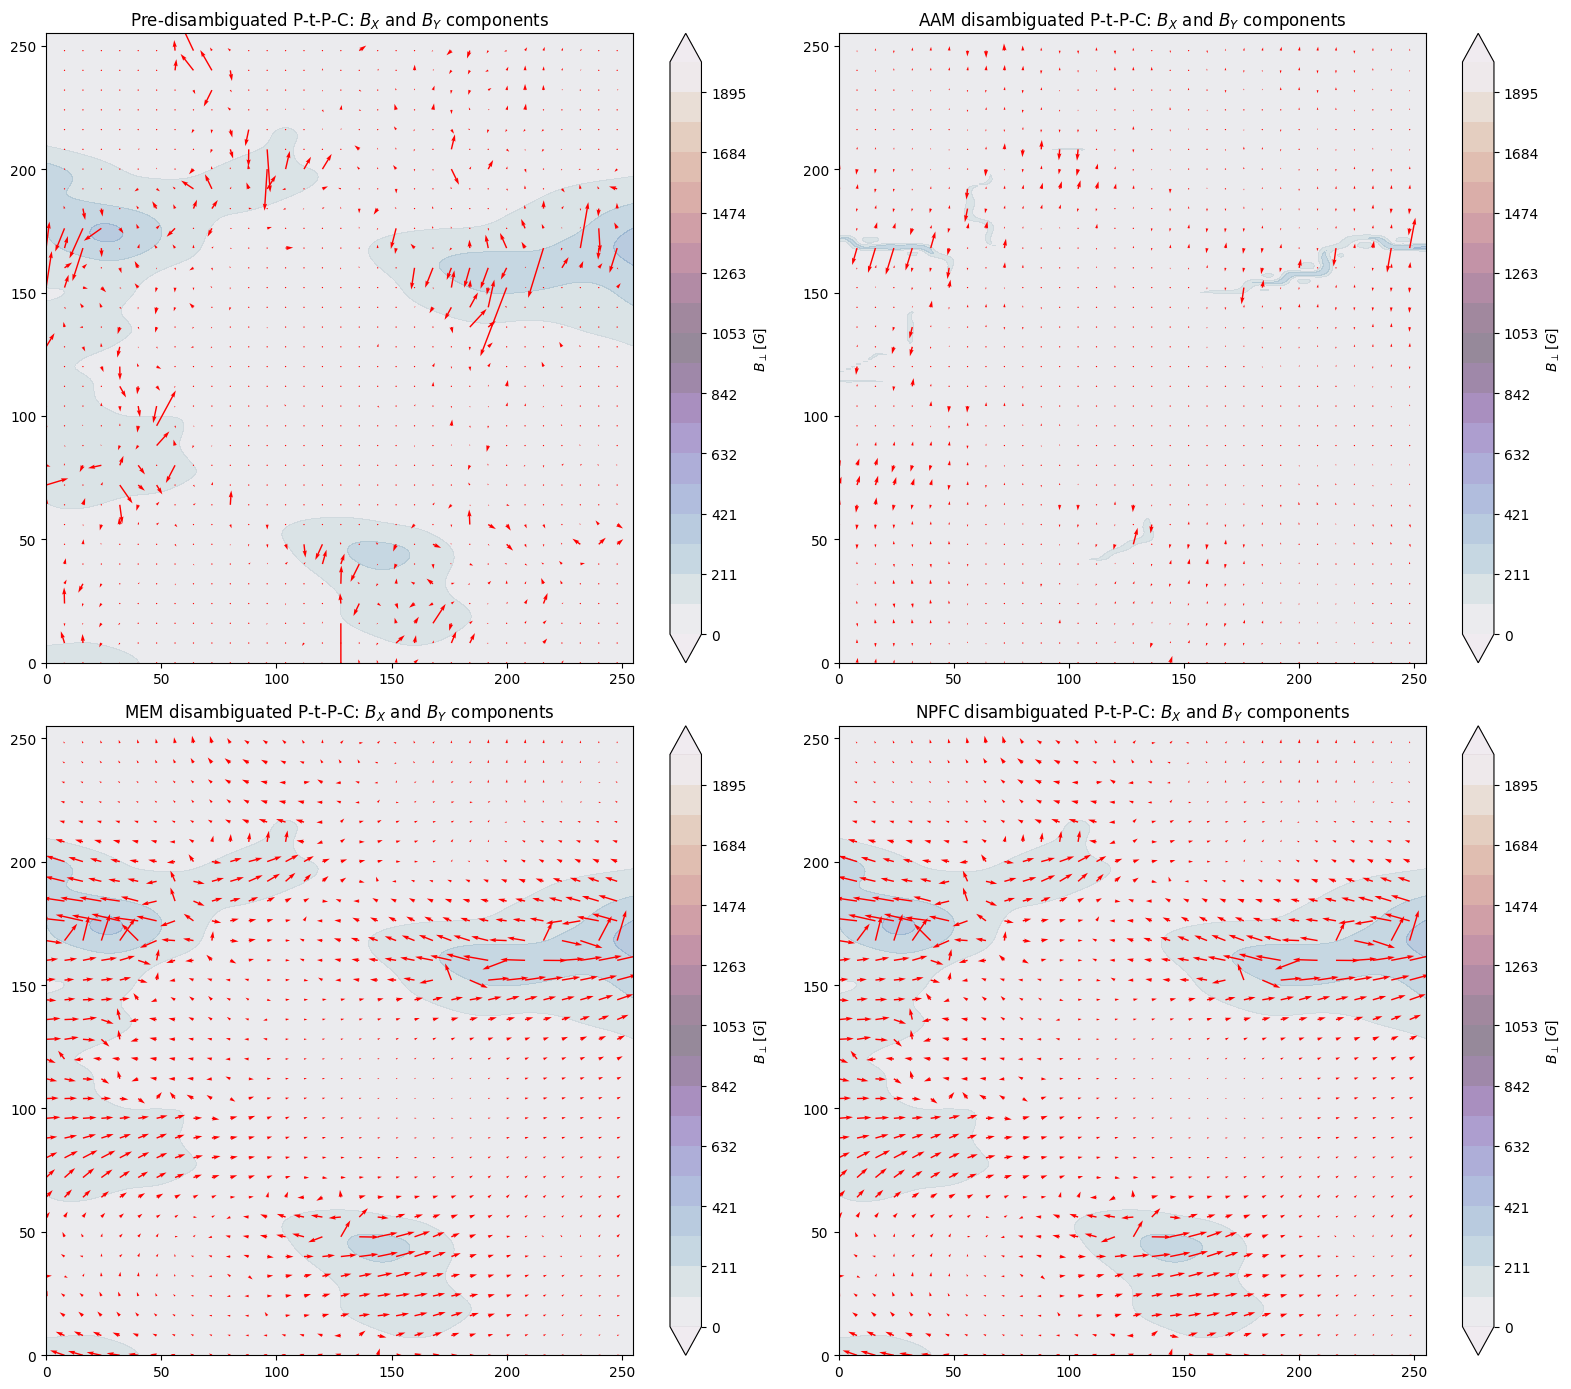

In [36]:
plt.figure(figsize=(16, 14))

levels = np.linspace(0, 2000, 20)  
plt.subplot(221)
contour = plt.contourf(Btr_ptpc, levels=levels, cmap='twilight', alpha=0.5, extend='both')
plt.colorbar(contour, label=r'$B_{\perp}\,[G]$')
plt.quiver(X, Y, Bx, By, color='red', angles='xy', scale_units='xy', lw=2, scale=25)
plt.title('Pre-disambiguated P-t-P-C: $B_X$ and $B_Y$ components')

plt.subplot(222)
contour = plt.contourf(Btr_aam_ptpc, levels=levels, cmap='twilight', alpha=0.5, extend='both')
plt.colorbar(contour, label=r'$B_{\perp}\,[G]$')
plt.quiver(X, Y, Bx_aam, By_aam, color='red', angles='xy', scale_units='xy', lw=2, scale=25)
plt.title('AAM disambiguated P-t-P-C: $B_X$ and $B_Y$ components')

plt.subplot(223)
contour = plt.contourf(Btr_mem_ptpc, levels=levels, cmap='twilight', alpha=0.5, extend='both')
plt.colorbar(contour, label=r'$B_{\perp}\,[G]$')
plt.quiver(X, Y, Bx_mem, By_mem, color='red', angles='xy', scale_units='xy', lw=2, scale=25)
plt.title('MEM disambiguated P-t-P-C: $B_X$ and $B_Y$ components')

plt.subplot(224)
contour = plt.contourf(Btr_npfc_ptpc, levels=levels, cmap='twilight', alpha=0.5, extend='both')
plt.colorbar(contour, label=r'$B_{\perp}\,[G]$')
plt.quiver(X, Y, Bx_npfc, By_npfc, color='red', angles='xy', scale_units='xy', lw=2, scale=25)
plt.title('NPFC disambiguated P-t-P-C: $B_X$ and $B_Y$ components')

plt.tight_layout()
plt.show()

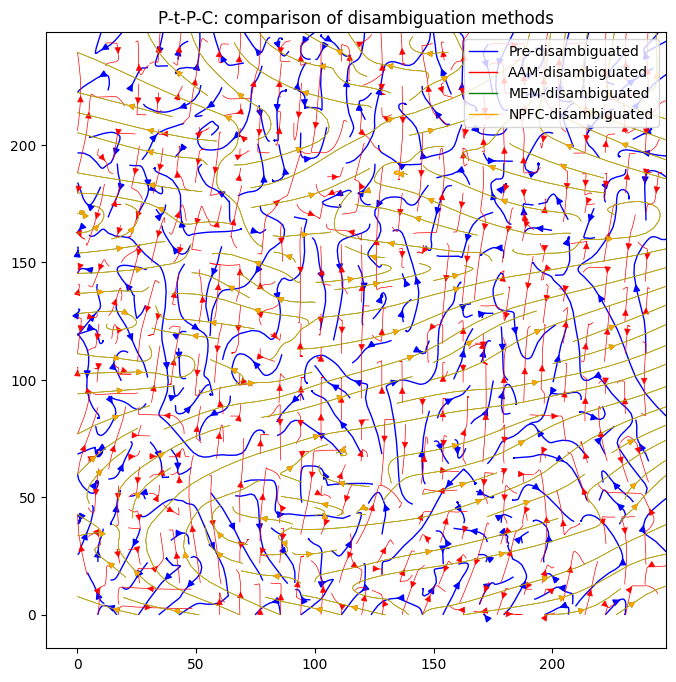

In [38]:
plt.figure(figsize=(8, 8))

sp1, sp2 = np.sqrt(Bx**2 + By**2), np.sqrt(Bx_aam**2 + By_aam**2)
sp3, sp4 = np.sqrt(Bx_mem**2 + By_mem**2), np.sqrt(Bx_npfc**2 + By_npfc**2)
#lw1, lw2, lw3, lw4 = 10*sp1/sp1.max(), 10*sp2/sp2.max(), 10*sp3/sp3.max(), 10*sp4/sp4.max()

plt.streamplot(X, Y, Bx/sp1.max(), By/sp1.max(), color='blue', linewidth=1)
plt.streamplot(X, Y, Bx_aam/sp2.max(), By_aam/sp2.max(), color='red', linewidth=0.5)
plt.streamplot(X, Y, Bx_mem/sp3.max(), By_mem/sp3.max(), color='green', linewidth=0.5)
plt.streamplot(X, Y, Bx_npfc/sp4.max(), By_npfc/sp4.max(), color='orange', linewidth=0.5)

legend_labels = ['Pre-disambiguated', 'AAM-disambiguated', 'MEM-disambiguated', 'NPFC-disambiguated']
legend_colors = ['blue', 'red', 'green', 'orange']
handles = [plt.Line2D([0], [0], color=color, lw=1) for color in legend_colors]
plt.title('P-t-P-C: comparison of disambiguation methods')
plt.legend(handles, legend_labels, loc="upper right")
plt.show()

#### S-c inferred data.

In [26]:
skip = 8
x, y = np.arange(0, B_orig.shape[1], skip), np.arange(0, B_orig.shape[0], skip)
X, Y = np.meshgrid(x, y)

Bx, By = Bx_orig[::skip, ::skip], By_orig[::skip, ::skip]
Bx_aam, By_aam = Bx_aam_spc[::skip, ::skip], By_aam_spc[::skip, ::skip]
Bx_mem, By_mem = Bx_mem_spc[::skip, ::skip], By_mem_spc[::skip, ::skip]
Bx_npfc, By_npfc = Bx_npfc_spc[::skip, ::skip], By_npfc_spc[::skip, ::skip]

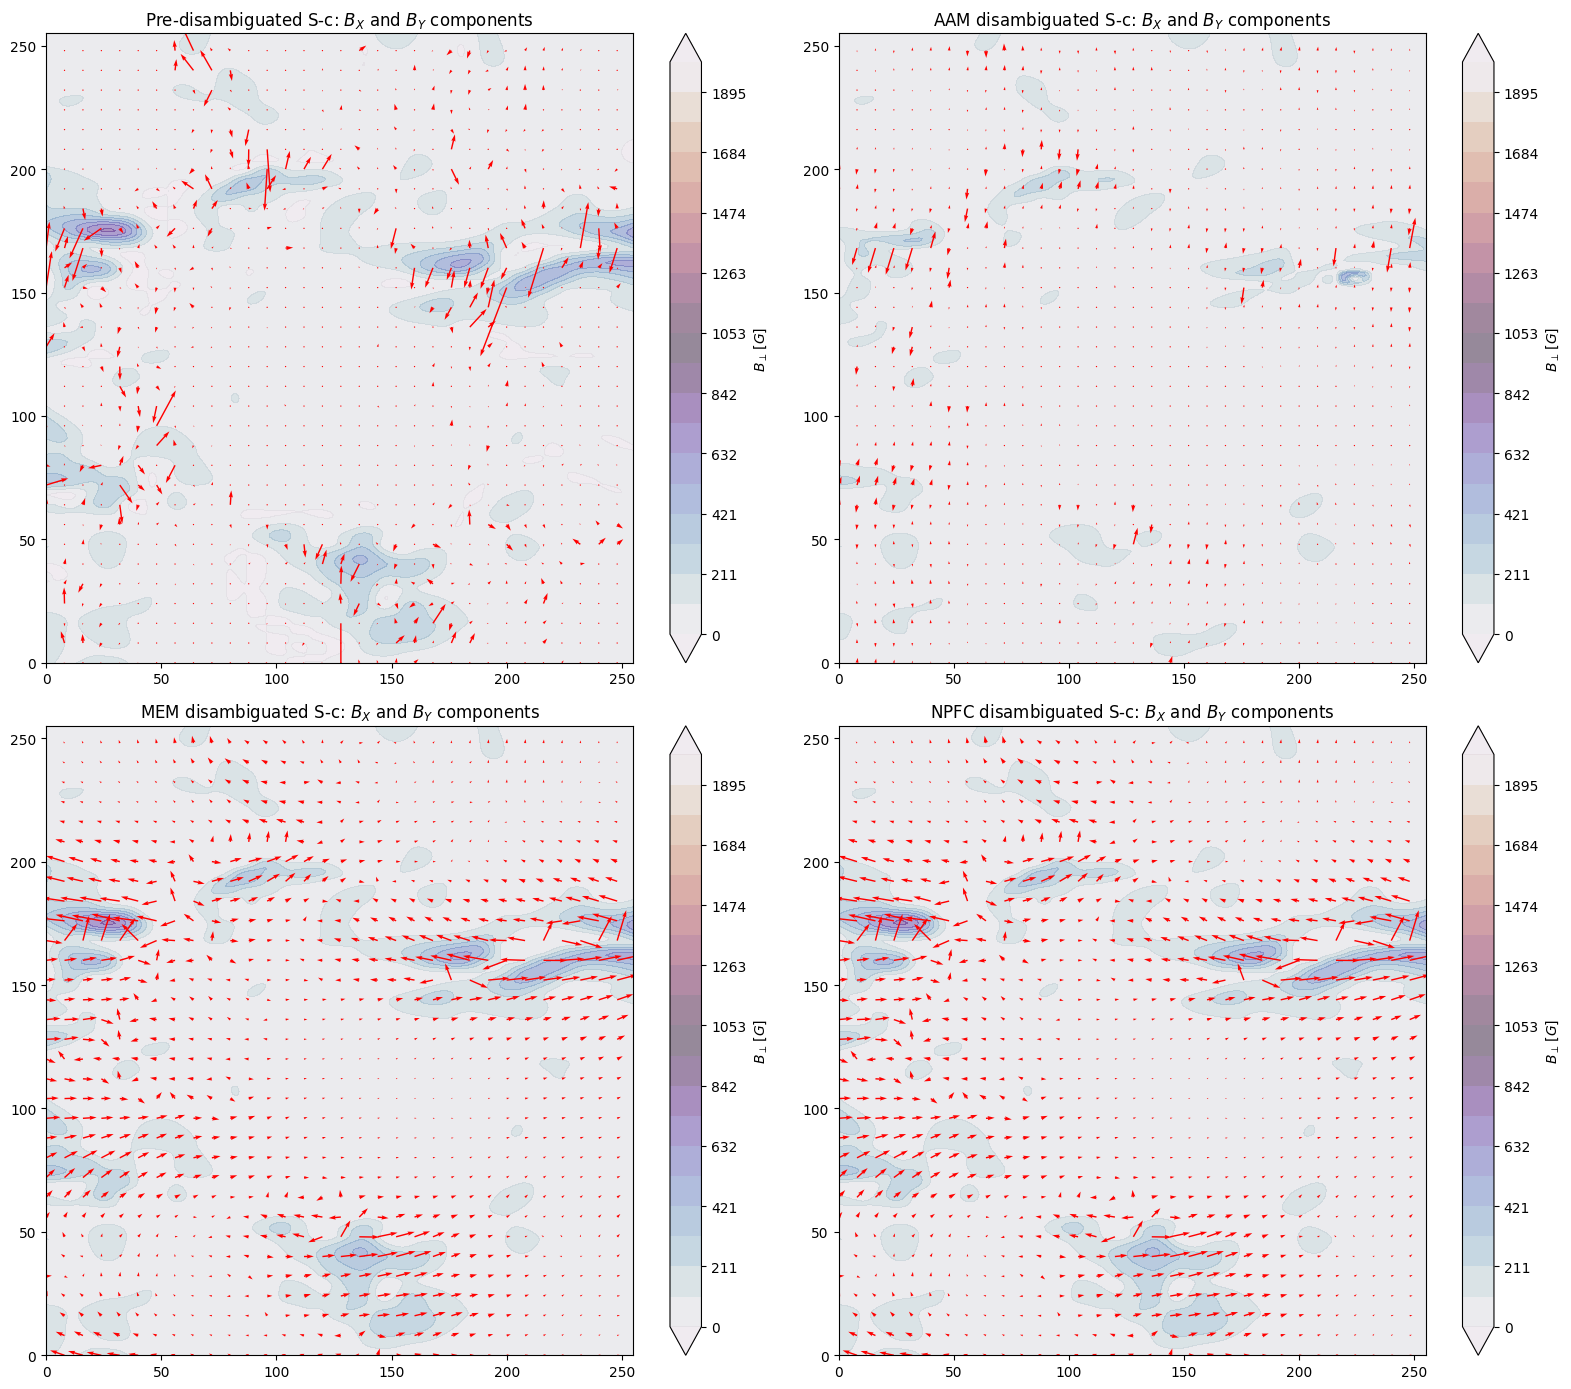

In [40]:
plt.figure(figsize=(16, 14))

levels = np.linspace(0, 2000, 20)  
plt.subplot(221)
contour = plt.contourf(Btr_spc, levels=levels, cmap='twilight', alpha=0.5, extend='both')
plt.colorbar(contour, label=r'$B_{\perp}\,[G]$')
plt.quiver(X, Y, Bx, By, color='red', angles='xy', scale_units='xy', lw=2, scale=25)
plt.title('Pre-disambiguated S-c: $B_X$ and $B_Y$ components')

plt.subplot(222)
contour = plt.contourf(Btr_aam_spc, levels=levels, cmap='twilight', alpha=0.5, extend='both')
plt.colorbar(contour, label=r'$B_{\perp}\,[G]$')
plt.quiver(X, Y, Bx_aam, By_aam, color='red', angles='xy', scale_units='xy', lw=2, scale=25)
plt.title('AAM disambiguated S-c: $B_X$ and $B_Y$ components')

plt.subplot(223)
contour = plt.contourf(Btr_mem_spc, levels=levels, cmap='twilight', alpha=0.5, extend='both')
plt.colorbar(contour, label=r'$B_{\perp}\,[G]$')
plt.quiver(X, Y, Bx_mem, By_mem, color='red', angles='xy', scale_units='xy', lw=2, scale=25)
plt.title('MEM disambiguated S-c: $B_X$ and $B_Y$ components')

plt.subplot(224)
contour = plt.contourf(Btr_npfc_spc, levels=levels, cmap='twilight', alpha=0.5, extend='both')
plt.colorbar(contour, label=r'$B_{\perp}\,[G]$')
plt.quiver(X, Y, Bx_npfc, By_npfc, color='red', angles='xy', scale_units='xy', lw=2, scale=25)
plt.title('NPFC disambiguated S-c: $B_X$ and $B_Y$ components')

plt.tight_layout()
plt.show()

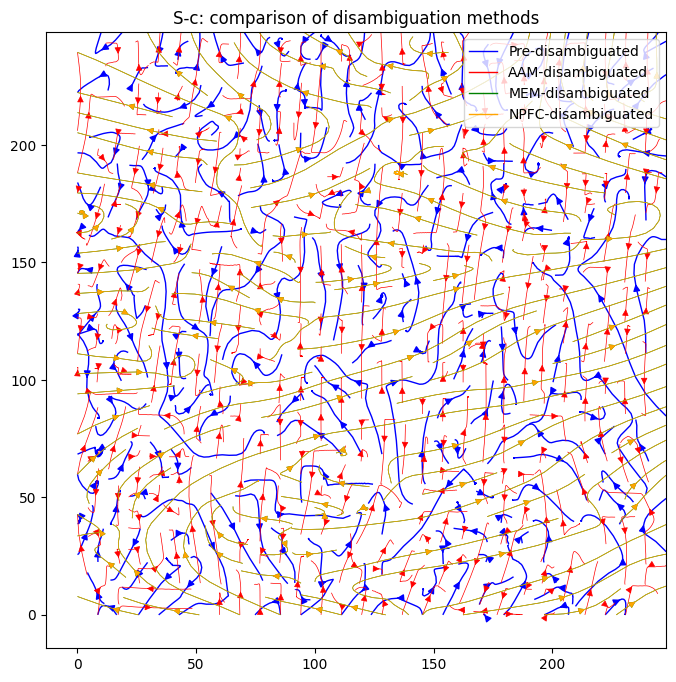

In [41]:
plt.figure(figsize=(8, 8))

sp1, sp2 = np.sqrt(Bx**2 + By**2), np.sqrt(Bx_aam**2 + By_aam**2)
sp3, sp4 = np.sqrt(Bx_mem**2 + By_mem**2), np.sqrt(Bx_npfc**2 + By_npfc**2)
#lw1, lw2, lw3, lw4 = 10*sp1/sp1.max(), 10*sp2/sp2.max(), 10*sp3/sp3.max(), 10*sp4/sp4.max()

plt.streamplot(X, Y, Bx/sp1.max(), By/sp1.max(), color='blue', linewidth=1)
plt.streamplot(X, Y, Bx_aam/sp2.max(), By_aam/sp2.max(), color='red', linewidth=0.5)
plt.streamplot(X, Y, Bx_mem/sp3.max(), By_mem/sp3.max(), color='green', linewidth=0.5)
plt.streamplot(X, Y, Bx_npfc/sp4.max(), By_npfc/sp4.max(), color='orange', linewidth=0.5)

legend_labels = ['Pre-disambiguated', 'AAM-disambiguated', 'MEM-disambiguated', 'NPFC-disambiguated']
legend_colors = ['blue', 'red', 'green', 'orange']
handles = [plt.Line2D([0], [0], color=color, lw=1) for color in legend_colors]
plt.title('S-c: comparison of disambiguation methods')
plt.legend(handles, legend_labels, loc="upper right")
plt.show()

#### $\color{red}{\text{Azimuth can't be restored after disambiguation, simply by using $B_x$ and $B_y$ - so, }}$

#### $\color{red}{\text{we disambiguated azimuth independently and we can analyze different scenarios.}} $

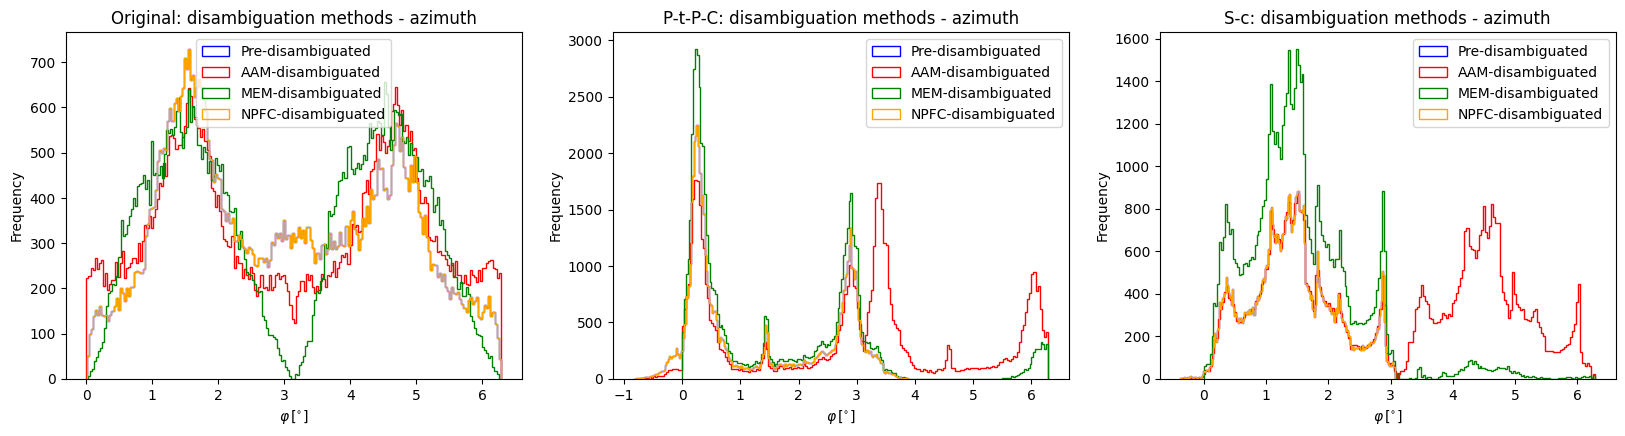

In [45]:
num_bins = 200
plt.figure(figsize=(20, 4.5))

plt.subplot(131)
plt.hist(az_orig.ravel(), num_bins, color='blue', label=r'Pre-disambiguated',
        histtype='step')
plt.hist(az_aam_orig.ravel(), num_bins, color='red', label=r'AAM-disambiguated',
        histtype='step')
plt.hist(az_mem_orig.ravel(), num_bins, color='green', label=r'MEM-disambiguated',
        histtype='step')
plt.hist(az_npfc_orig.ravel(), num_bins, color='orange', label=r'NPFC-disambiguated',
        histtype='step')

plt.title('Original: disambiguation methods - azimuth')
plt.xlabel(r'$\varphi\,[^{\circ}]$')
plt.ylabel(r'Frequency')
plt.legend()

plt.subplot(132)
plt.hist(az_ptpc.ravel(), num_bins, color='blue', label=r'Pre-disambiguated',
        histtype='step')
plt.hist(az_aam_ptpc.ravel(), num_bins, color='red', label=r'AAM-disambiguated',
        histtype='step')
plt.hist(az_mem_ptpc.ravel(), num_bins, color='green', label=r'MEM-disambiguated',
        histtype='step')
plt.hist(az_npfc_ptpc.ravel(), num_bins, color='orange', label=r'NPFC-disambiguated',
        histtype='step')

plt.title('P-t-P-C: disambiguation methods - azimuth')
plt.xlabel(r'$\varphi\,[^{\circ}]$')
plt.ylabel(r'Frequency')
plt.legend()

plt.subplot(133)
plt.hist(az_spc.ravel(), num_bins, color='blue', label=r'Pre-disambiguated',
        histtype='step')
plt.hist(az_aam_spc.ravel(), num_bins, color='red', label=r'AAM-disambiguated',
        histtype='step')
plt.hist(az_mem_spc.ravel(), num_bins, color='green', label=r'MEM-disambiguated',
        histtype='step')
plt.hist(az_npfc_spc.ravel(), num_bins, color='orange', label=r'NPFC-disambiguated',
        histtype='step')

plt.title('S-c: disambiguation methods - azimuth')
plt.xlabel(r'$\varphi\,[^{\circ}]$')
plt.ylabel(r'Frequency')
plt.legend()

plt.show()

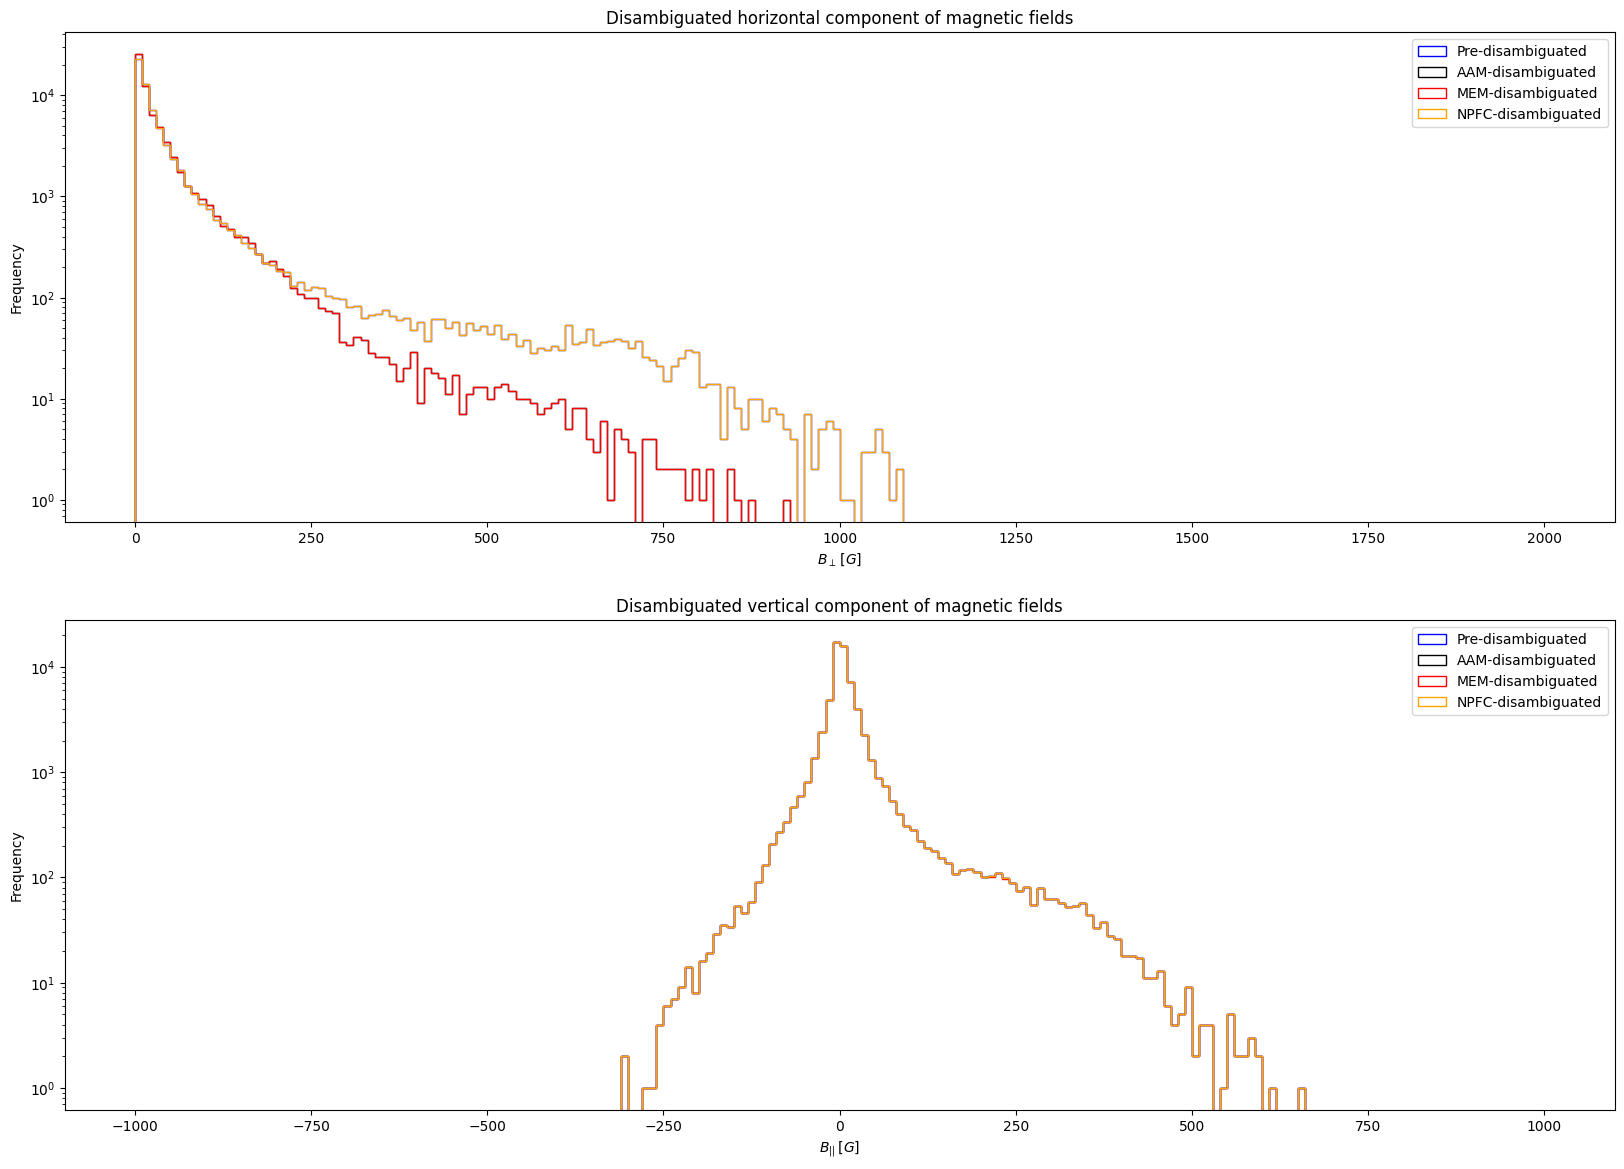

In [46]:
num_bins = 200
plt.figure(figsize=(20, 14))

plt.subplot(211)
plt.hist(Btr_orig.ravel(), num_bins, color='blue', label=r'Pre-disambiguated',
        histtype='step', range=(0, 2000))
plt.hist(Btr_aam_orig.ravel(), num_bins, color='black', label=r'AAM-disambiguated', 
        histtype='step', range=(0, 2000))
plt.hist(Btr_aam_orig.ravel(), num_bins, color='red', label=r'MEM-disambiguated', 
        histtype='step', range=(0, 2000))
plt.hist(Btr_npfc_orig.ravel(), num_bins, color='orange', label=r'NPFC-disambiguated',
        histtype='step', range=(0, 2000))

plt.title('Disambiguated horizontal component of magnetic fields')
plt.xlabel(r'$B_{\perp}\,[G]$')
plt.ylabel(r'Frequency')
plt.legend()
plt.yscale('log')

plt.subplot(212)
plt.hist(Bz_orig.ravel(), num_bins, color='blue', label=r'Pre-disambiguated',
        histtype='step', range=(-1000, 1000))
plt.hist(Bz_aam_orig.ravel(), num_bins, color='black', label=r'AAM-disambiguated', 
        histtype='step', range=(-1000, 1000))
plt.hist(Bz_mem_orig.ravel(), num_bins, color='red', label=r'MEM-disambiguated', 
        histtype='step', range=(-1000, 1000))
plt.hist(Bz_npfc_orig.ravel(), num_bins, color='orange', label=r'NPFC-disambiguated',
        histtype='step', range=(-1000, 1000))

plt.title('Disambiguated vertical component of magnetic fields')
plt.xlabel(r'$B_{||}\,[G]$')
plt.ylabel(r'Frequency')
plt.legend()
plt.yscale('log')

plt.show()